# Product Analysis (EDA)

This notebook focuses on understanding product using cleaned retail transaction data.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 6)

In [56]:
df = pd.read_csv('../data/processed/online_retail_cleaned.csv')
#df = df[df['IsCancellation'] != True]

### 1. Revenue vs Quantity Sold

In [57]:
# Question: How to calculate total quantity sold and revenue per product?
product_df = df.groupby(['StockCode']).agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

product_df.rename(columns={'TotalPrice': 'Revenue'}, inplace=True)
product_df


,StockCode,Quantity,Revenue
0,10002,1037,759.89
1,10080,495,119.09
2,10120,192,40.32
3,10123C,-13,3.25
4,10123G,-38,0.00
...,...,...,...
4065,gift_0001_20,20,167.05
4066,gift_0001_30,37,175.53
4067,gift_0001_40,3,100.70
4068,gift_0001_50,4,167.56


In [58]:
# Question: Which products are top revenue generators and top sellers?
top_revenue_products = product_df.sort_values(by='Revenue', ascending=False).head(10)
top_quantity_products = product_df.sort_values(by='Quantity', ascending=False).head(10)

print("Top 10 Products by Revenue:")
#print(top_revenue_products[['StockCode','Description','Revenue','Quantity']])
print(top_revenue_products[['StockCode','Revenue','Quantity']])

print("\nTop 10 Products by Quantity Sold:")
print(top_quantity_products[['StockCode','Revenue','Quantity']])

Top 10 Products by Revenue:
     StockCode    Revenue  Quantity
4059       DOT  206245.48      1707
1348     22423  164459.49     12954
2733     47566   98243.88     18010
3536    85123A   97838.45     38811
3515    85099B   92175.79     47260
1982     23084   66661.63     30597
4062      POST   66230.64      6353
1043     22086   63715.24     18876
3305     84879   58792.42     36122
2924     79321   53746.66     10339

Top 10 Products by Quantity Sold:
     StockCode   Revenue  Quantity
1147     22197  50967.92     56427
2997     84077  13560.09     53751
3515    85099B  92175.79     47260
3536    85123A  97838.45     38811
3305     84879  58792.42     36122
454      21212  21047.07     36016
1982     23084  66661.63     30597
1412     22492  16810.42     26437
1530     22616   7967.82     26299
966      21977  12170.77     24719


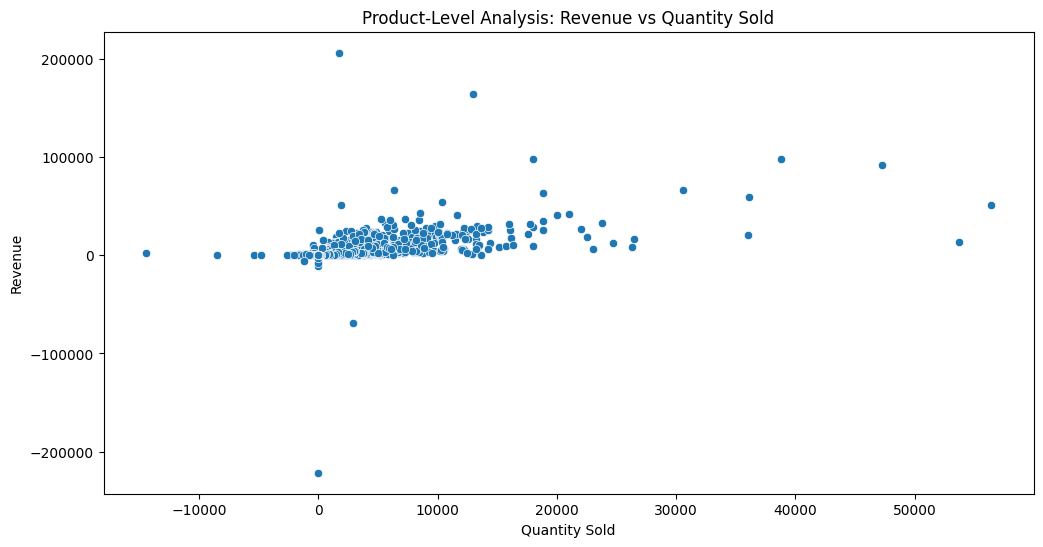

In [59]:
# Question: How do revenue and quantity compare across products?
plt.figure(figsize=(12,6))
sns.scatterplot(data=product_df, x='Quantity', y='Revenue')
plt.title('Product-Level Analysis: Revenue vs Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Revenue')
plt.show()


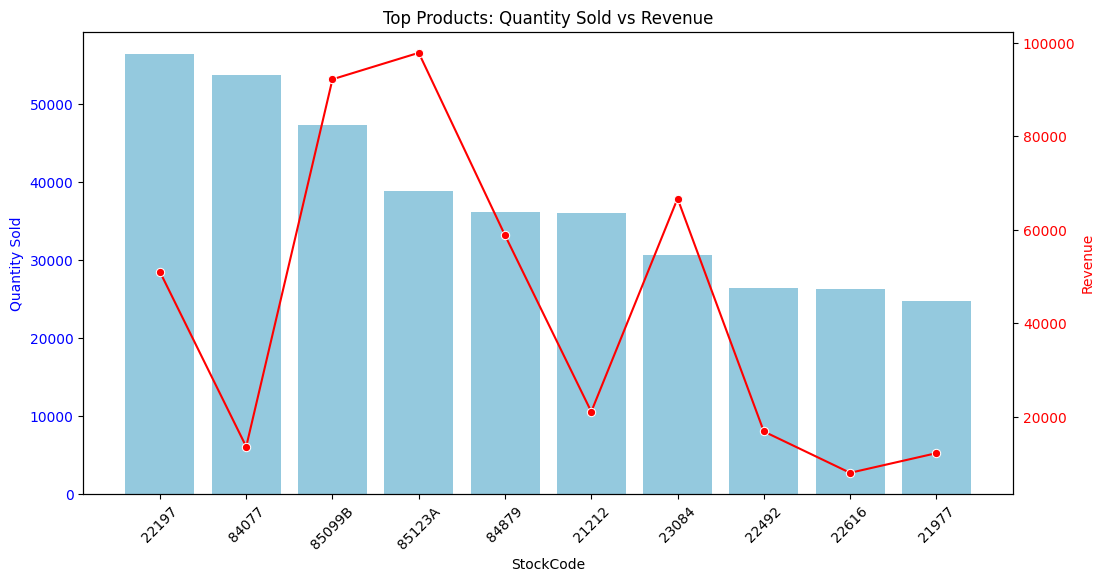

In [60]:
# Visualize top-selling products and their revenue
fig, ax1 = plt.subplots(figsize=(12,6))

#  Quantity Sold
sns.barplot(data=top_quantity_products, x='StockCode', y='Quantity', color='skyblue', ax=ax1)
ax1.set_ylabel('Quantity Sold', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=45)

# Revenue
ax2 = ax1.twinx()
sns.lineplot(data=top_quantity_products, x='StockCode', y='Revenue', color='red', marker='o', ax=ax2)
ax2.set_ylabel('Revenue', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Top Products: Quantity Sold vs Revenue')
plt.show()


#### Results/Interpretation:

- Majority cluster near the origin: Most products are sold in moderate quantities and generate moderate revenue.
- High-revenue outliers: A few products generate very high revenue even with relatively lower quantity sold — these are premium or high-priced products.
- High-quantity outliers: Some products are sold in large volumes but generate less revenue, indicating low-priced, high-volume items.
- No strict linear correlation: Revenue does not increase proportionally with quantity for all products — shows that both price and volume affect revenue.
- Business insight: Focus marketing, promotions, and inventory management on high-revenue products, while ensuring sufficient stock for high-volume sellers to maintain overall sales.

### 2. Product Seasonality

In [61]:
# Question: How to calculate monthly sales for each product?
monthly_sales = df.groupby(['StockCode', 'Description', 'Year', 'Month']).agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

monthly_sales.rename(columns={'TotalPrice': 'Revenue'}, inplace=True)
# Question: Which products show consistent sales growth over months?
# (require more complex time series analysis; placeholder for now)

In [65]:
# Question: Which products should we focus on for seasonality?
top_products = df.groupby(['StockCode', 'Description'])['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_products = top_products.reset_index()

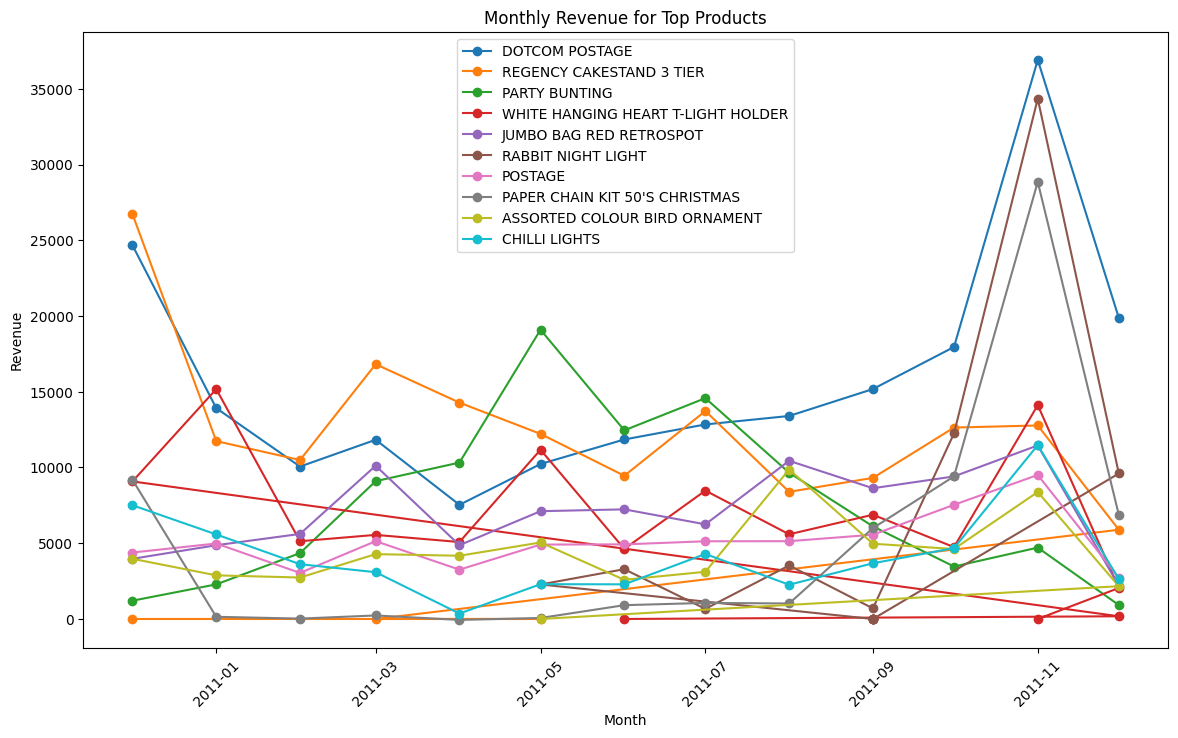

In [63]:
# Revenue-based Seasonality
plt.figure(figsize=(14,8))

for _, row in top_products.iterrows():
    product_data = monthly_sales[(monthly_sales['StockCode'] == row['StockCode'])].copy()
    product_data['YearMonth'] = pd.to_datetime(product_data[['Year','Month']].assign(DAY=1))
    plt.plot(product_data['YearMonth'], product_data['Revenue'], marker='o', label=row['Description'])

plt.title('Monthly Revenue for Top Products')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.show()

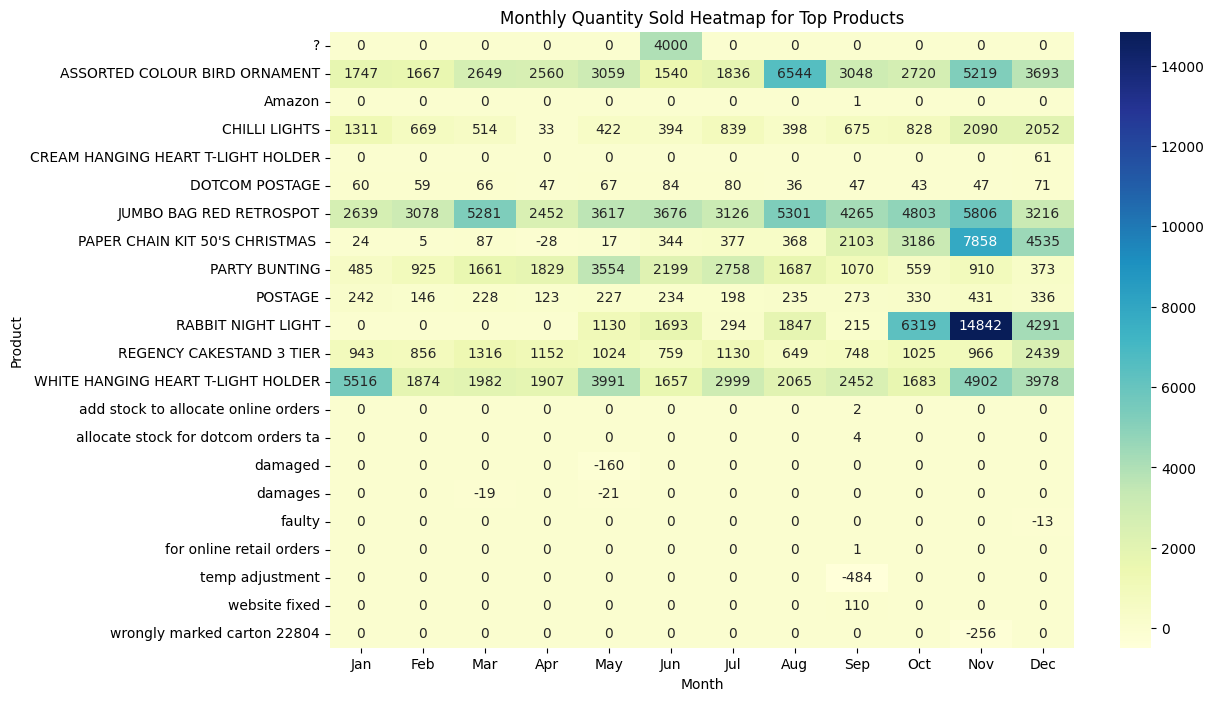

In [ ]:
# Question: How to visualize seasonality for top products using a heatmap?

import calendar

heatmap_data = monthly_sales[monthly_sales['StockCode'].isin(top_products['StockCode'])].copy()
heatmap_data['YearMonth'] = pd.to_datetime(heatmap_data[['Year','Month']].assign(DAY=1))

# Sort by YearMonth
heatmap_data = heatmap_data.sort_values('YearMonth')

# Create month abbreviation column
heatmap_data['MonthName'] = heatmap_data['Month'].apply(lambda x: calendar.month_abbr[x])

# Pivot: product as rows, month as columns, sum of quantity
heatmap_pivot = heatmap_data.pivot_table(
    index='Description',
    columns='MonthName',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

# Ensure months are in calendar order
month_order = [calendar.month_abbr[i] for i in range(1,13)]
heatmap_pivot = heatmap_pivot[month_order]

# Plot
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Monthly Quantity Sold Heatmap for Top Products')
plt.xlabel('Month')
plt.ylabel('Product')
plt.show()



#### Results/Interpretation:

- Clear seasonality: Most top products peak in late summer to winter (Aug–Dec), especially Nov–Dec, indicating strong holiday demand.

- Best sellers:

     - RABBIT NIGHT LIGHT, JUMBO BAG RED RETROSPOT, and ASSORTED COLOUR BIRD ORNAMENT show consistently high volumes, with sharp spikes toward year-end.

- Holiday effect: Products like PAPER CHAIN KIT 50’S CHRISTMAS surge dramatically in Nov–Dec, confirming Christmas-driven sales.

Returns/adjustments: Negative values (e.g., damaged, temp adjustment) represent returns or stock corrections, not actual sales.
Low-value rows (e.g., “Amazon”, “website fixed”) are system or operational entries, not products.

- Overall: Sales are highly seasonal, with a small set of products driving most volume, especially during the holiday period.